In [1]:
using Gadfly, RDatasets
import ForwardDiff: gradient

### Sanity check

In [2]:
f(x) = sum(x)*log(abs(sum(x)))
f([2,5])

13.621371043387192

In [3]:
gradient(f, [2,5])

2-element Array{Float64,1}:
 2.94591
 2.94591

### Generic gradient descent

In [4]:
function GradientDescent(L, x0; rate=.1, N=100, eps=.001)
    for i = 1:N 
        ∇L = gradient(L, x0)
        if norm(∇L) < eps
            break
        end
        x0 -= rate * ∇L
    end
    x0
end

GradientDescent (generic function with 1 method)

### Curve fitting

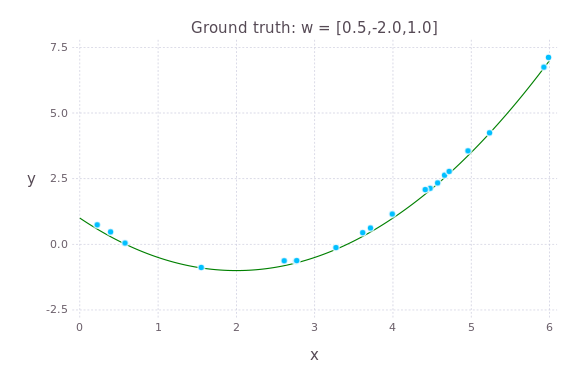

In [5]:
x = rand(20) * 6
w = [.5; -2.; 1]
y = [x.^2  x  ones(x)] * w  + rand(size(x)) * .2
#         ^^^                      ^^^
#   2nd degree polynomial       Noisy data

p = plot(
    layer(x=x, y=y, Geom.point),
    layer(x -> dot([x^2; x; 1], w), 0, 6, Theme(default_color=colorant"green")),
    Guide.title("Ground truth: w = $w"))
draw(PNG(6inch, 4inch), p)

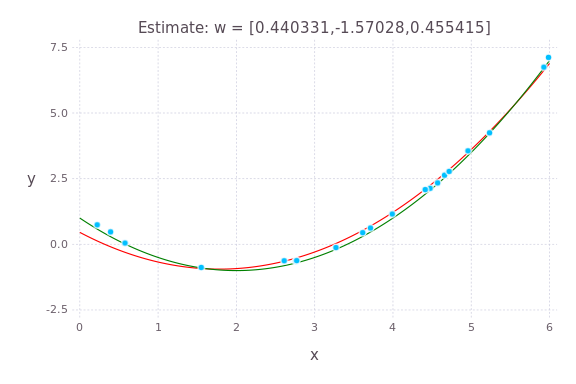

In [6]:
esw = GradientDescent([1,1,1], rate=.001, N=5000) do w
    mean(([x.^2  x  ones(x)] * w - y).^2)
end

p = plot(
    layer(x=x, y=y, Geom.point),
    layer(x -> dot([x^2; x; 1], w), 0, 6, Theme(default_color=colorant"green")),
    layer(x -> dot([x^2; x; 1], esw), 0, 6, Theme(default_color=colorant"red")),
    Guide.title("Estimate: w = $esw"))
draw(PNG(6inch, 4inch), p)

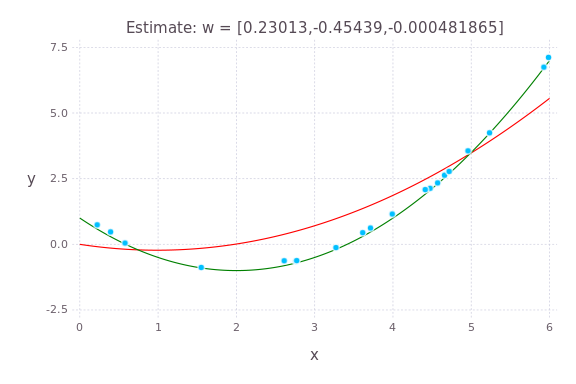

In [7]:
# With L1 regularization

esw = GradientDescent([1,1,1], rate=.001, N=5000) do w
    mean(([x.^2  x  ones(x)] * w - y).^2) + sum(abs(w))
end

p = plot(
    layer(x=x, y=y, Geom.point),
    layer(x -> dot([x^2; x; 1], w), 0, 6, Theme(default_color=colorant"green")),
    layer(x -> dot([x^2; x; 1], esw), 0, 6, Theme(default_color=colorant"red")),
    Guide.title("Estimate: w = $esw"))
draw(PNG(6inch, 4inch), p)

### Iris dataset

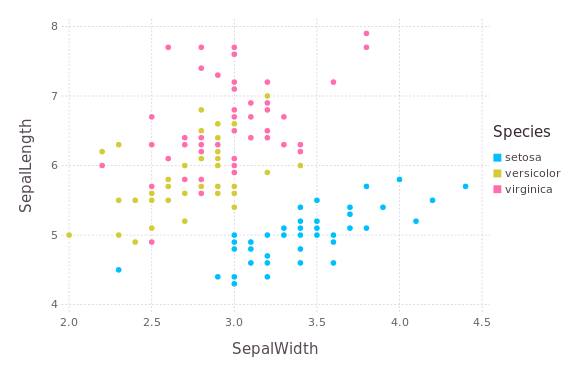

In [8]:
iris = dataset("datasets", "iris")
p = plot(iris, x=:SepalWidth, y=:SepalLength, color=:Species)
draw(PNG(6inch, 4inch), p)

In [9]:
# Classify setosa vs. rest
X = convert(Array, iris[[:SepalWidth, :SepalLength, :PetalWidth]])
y = convert(Array{Int64}, iris[:Species] .== "setosa");

### Logistic Regression

In [10]:
logit(x,w) = 1 / (1 + exp(-dot([x; 1], w)))

logisticRegression(X,y) =
    GradientDescent(rand(size(X,2)+1)) do w
        # Loss is negative log likelihood
        e = 0
        for i = 1:size(X,1) # <<< A loop over run time data
            if y[i] == 0    # << Branch using run time data
                e += log(1-logit(X[i,:], w))
            else
                e += log(logit(X[i,:], w))
            end
        end
        -e/size(X,1)
    end

logisticRegression (generic function with 1 method)

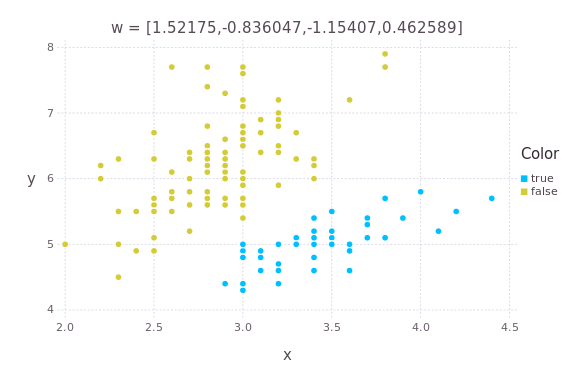

In [11]:
w = logisticRegression(X,y)
pred = [logit(X[i,:], w) > .5 for i = 1:size(X,1)]
p = plot(x=X[:,1], y=X[:,2], color=pred, Guide.title("w = $w"))
draw(PNG(6inch, 4inch), p)

### Bagging Gradient Descent

In [12]:
baggingLogisticRegression(X,y) =
    GradientDescent(rand(size(X,2)+1)) do w
        e = 0
        for k = 1:size(X,1)*.6
        
            i = rand(1:size(X,1)) # <<< Random state!
    
            if y[i] == 0
                e += log(1-logit(X[i,:], w))
            else
                e += log(logit(X[i,:], w))
            end
        end
        -e/(size(X,1)*.6)
    end

baggingLogisticRegression (generic function with 1 method)

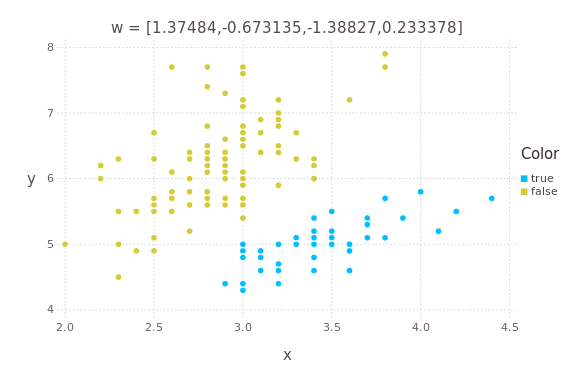

In [13]:
w = baggingLogisticRegression(X,y)
pred = [logit(X[i,:], w) > .5 for i = 1:size(X,1)]
p = plot(x=X[:,1], y=X[:,2], color=pred, Guide.title("w = $w"))
draw(PNG(6inch, 4inch), p)